<font color='black' size='5'>To be added:</font>
1. Data visualization for default features.
1. inferences from that data.
1. New features based on those inferences (Partially done).
1. Specified preprocessing for the various features.

using the nbextention "Initialization cells", I first of all save the standard output to the notebook, as it changes with each kernel. <br>
The condition makes sure that no matter what happens, as long as I don't go out of my way to screw up, `saved_std` is always the original standard output.  
This was done so that I can output the verbose cross-validation grids to the terminal without bogging down this notebook.

In [2]:
import sys

if str(type(sys.stdout)) == "<class 'ipykernel.iostream.OutStream'>":
    saved_std = sys.stdout
else:
    sys.stdout = saved_std

import warnings
warnings.filterwarnings('ignore') ## Not sure what this does anymore :(
sys.stdout

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import itertools
from math import ceil

In [5]:
'''
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              AdaBoostClassifier,ExtraTreesClassifier, VotingClassifier)
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn import metrics
from scipy.stats import uniform
'''

print("These are kept here for now. This used to be both the modeling and preprocessing notebook.")

These are kept here for now. This used to be both the modeling and preprocessing notebook.


In [35]:
df = pd.read_csv('Data/train.csv', index_col='PassengerId').fillna(value={'Cabin':'Unknown'})
test = pd.read_csv('Data/test.csv', index_col='PassengerId').fillna(value={'Cabin':'Unknown'})
# y = df['Survived']
# df.drop(['Survived'],axis=1,inplace=True)
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknown,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,Unknown,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,Unknown,S


Note that only people with a Pclass of 1 have a cabin. Which makes sense since they are the richest.

In [36]:
df.isna().sum() 
# I understand this is missing Cabin's count. 
# However, IMO it's not important, we expect most wouldn't have a cabin.

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin         0
Embarked      2
dtype: int64

We'll impute AGE's missing values using a pipeline and averages to avoid data leakage and EMBARKED's with modal values.

A feature which may be very useful is the person's title, as it contains both gender and economic status.<br>
The method by which I find all possible titles and assign each person a title is taken from __[here](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)__.

In [37]:
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if big_string.find(substring) != -1:
            return substring
    print(big_string)
    return None

In [38]:
# Titles = ['Mr','Mrs','Miss','Master'] 

# # all other titles must be found and entered by hand
# # since there is no pattern to their placement
# for Name in df['Name']:
#     if substrings_in_string(Name,Titles) == None:
#         Title = input("Please enter this person's title:")
#         Titles.append(Title)

# for Name in test['Name']:
#     if substrings_in_string(Name,Titles) == None:
#         Title = input("Please enter this person's title:")
#         Titles.append(Title)

Titles = ['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme',
          'Ms', 'Major', 'Mlle', 'Col', 'Capt', 'Countess', 'Jonkheer']


df['Title'] = df['Name'].apply(substrings_in_string, substrings=Titles)
test['Title'] = test['Name'].apply(substrings_in_string, substrings=Titles)

The list of titles is quite big and contains many titles that appear with a very low frequency.<br>
I'd like to simplify them, the method by which I reduce the number of titles is also taken from __[here](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)__.

In [39]:
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

In [40]:
df['Title'] = df.apply(replace_titles, axis=1)
test['Title'] = test.apply(replace_titles, axis=1)

The deck which a person stayed on may be relevant, as some cabins were closer to the lifeboats.<br>
However, this column contains by far the highest percentage of missing data which may hurt the model.

In [41]:
df['Deck'] = [Cab[0] for Cab in df['Cabin']]
test['Deck'] = [Cab[0] for Cab in test['Cabin']]
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S,Mr,U
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mr,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,Miss,U
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mr,C
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknown,S,Mr,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,Unknown,S,Mr,U
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss,B
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,Unknown,S,Miss,U


In [ ]:
# Ages will get ranges using bins with equal (# of Datapoints). The first range will be 0-13

In [115]:
def PercentPivot(df, index, columns):
    # Assuming index has 2 values
    table = df[[index,columns]].pivot_table(index=index, columns=columns, aggfunc=len).fillna(0)
    table['Sum'] = pd.Series([table.iloc[0,:].sum(),table.iloc[1,:].sum()]) # Sanity check and benchmark.
    cols = table.columns.to_list() # Unsure how to deal with multiple columns in 'columns'
    pcents = []
    for i in range(len(cols)):
        pcents.append(table.iloc[1,i]/table.iloc[:,i].sum() * 100)
    return pd.concat([table,pd.DataFrame([pcents], columns=cols, index = ['%'])])

,1,2,3,Sum
0,80.000000,97.000000,372.000000,549.000000
1,136.000000,87.000000,119.000000,342.000000
%,62.962963,47.282609,24.236253,38.383838


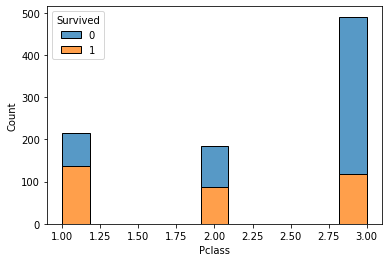

In [116]:
sns.histplot(data=df, x='Pclass', hue='Survived', multiple='stack')
PercentPivot(df, 'Survived', 'Pclass')

,female,male,Sum
0,81.000000,468.000000,549.000000
1,233.000000,109.000000,342.000000
%,74.203822,18.890815,38.383838


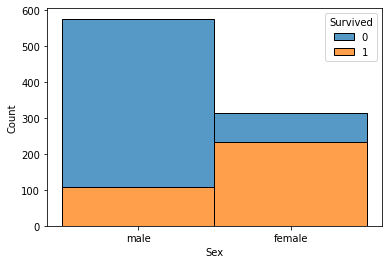

In [117]:
sns.histplot(data=df, x='Sex', hue='Survived', multiple='stack')
PercentPivot(df, 'Survived', 'Sex')

,0,1,2,3,4,5,8,Sum
0,398.000000,97.000000,15.000000,12.0,15.000000,5.0,7.0,549.000000
1,210.000000,112.000000,13.000000,4.0,3.000000,0.0,0.0,342.000000
%,34.539474,53.588517,46.428571,25.0,16.666667,0.0,0.0,38.383838


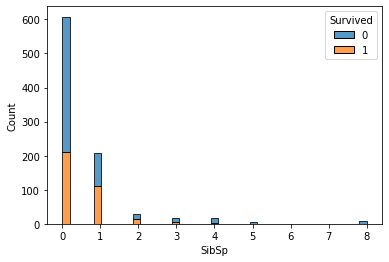

In [118]:
sns.histplot(data=df, x='SibSp', hue='Survived', multiple='stack')
PercentPivot(df, 'Survived', 'SibSp')

From this we gather that having 3 or more siblings/spouses(?) on board is likely to negatively affect your chances.  
Having 1 or 2 siblings/spouses on board is likely to positively affect your chances.  
And not having a spouse or sibling on board may negatively affect your chances slightly.  
In my opinion, the binary features "Has 1 or 2 SibSp" and "Has 3 or more SibSp" are worth exploring.

,0.42,0.67,0.75,0.83,0.92,1.0,2.0,3.0,4.0,5.0,...,63.0,64.0,65.0,66.0,70.0,70.5,71.0,74.0,80.0,Sum
0,0.0,0.0,0.0,0.0,0.0,2.000000,7.0,1.000000,3.0,0.0,...,0.0,2.0,3.0,1.0,2.0,1.0,2.0,1.0,0.0,424.000000
1,1.0,1.0,2.0,2.0,1.0,5.000000,3.0,5.000000,7.0,4.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,290.000000
%,100.0,100.0,100.0,100.0,100.0,71.428571,30.0,83.333333,70.0,100.0,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,40.616246


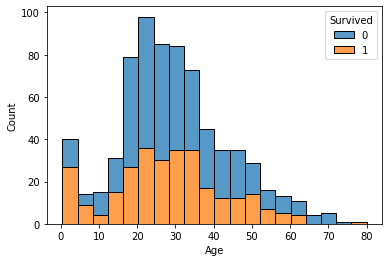

In [119]:
sns.histplot(data=df, x='Age', hue='Survived', multiple='stack')
PercentPivot(df, 'Survived', 'Age') ## Can't deal with continous values, there are many missing values.

,0.0,4.0125,5.0,6.2375,6.4375,6.45,6.4958,6.75,6.8583,6.95,...,164.8667,211.3375,211.5,221.7792,227.525,247.5208,262.375,263.0,512.3292,Sum
0,14.000000,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,0.0,549.000000
1,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,0.0,0.0,3.0,1.0,2.0,2.0,3.0,342.000000
%,6.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100.0,100.0,0.0,0.0,75.0,50.0,100.0,50.0,100.0,38.383838


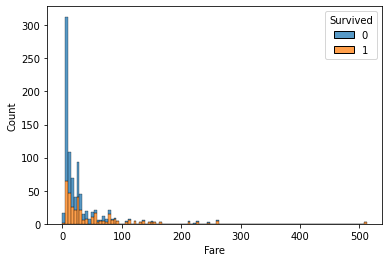

In [120]:
sns.histplot(data=df, x='Fare', hue='Survived', multiple='stack')
PercentPivot(df, 'Survived', 'Fare') ## Can't deal with continous values

,C,Q,S,Sum
0,75.000000,47.000000,427.000000,549.000000
1,93.000000,30.000000,217.000000,340.000000
%,55.357143,38.961039,33.695652,38.245219


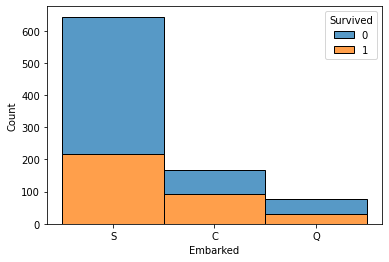

In [121]:
sns.histplot(data=df, x='Embarked', hue='Survived', multiple='stack')
PercentPivot(df, 'Survived', 'Embarked') # Notice the 'Sum' column, it shows there are 2 missing survivors.

,Master,Miss,Mr,Mrs,Sum
0,17.0,54.00000,474.000000,4.000000,549.000000
1,23.0,128.00000,186.000000,5.000000,342.000000
%,57.5,70.32967,28.181818,55.555556,38.383838


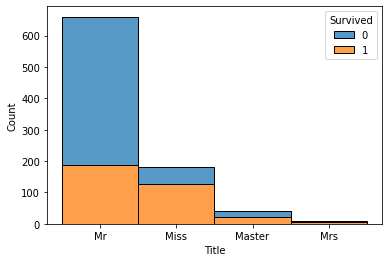

In [122]:
sns.histplot(data=df, x='Title', hue='Survived', multiple='stack')
PercentPivot(df, 'Survived', 'Title')

,A,B,C,D,E,F,G,T,U,Sum
0,8.000000,12.000000,24.000000,8.000000,8.0,5.000000,2.0,1.0,481.000000,549.000000
1,7.000000,35.000000,35.000000,25.000000,24.0,8.000000,2.0,0.0,206.000000,342.000000
%,46.666667,74.468085,59.322034,75.757576,75.0,61.538462,50.0,0.0,29.985444,38.383838


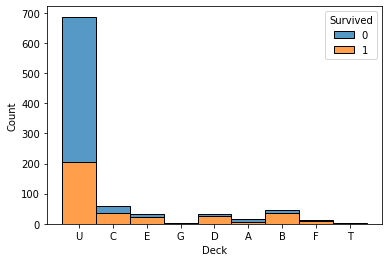

In [123]:
sns.histplot(data=df, x='Deck', hue='Survived', multiple='stack')
PercentPivot(df, 'Survived', 'Deck')

We'll handle different data types differently in our preprocessing.<br>
The pipelines help adding other transformers later and keeping things consistent.<br>
The binary columns don't need an Imputer since they don't have any missing data in both datasets.

In [266]:
Numerical_Pre = make_pipeline(SimpleImputer(strategy='mean'))
OneHot_Pre = make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(handle_unknown = 'ignore'))

Col_Num = ['Age','Fare','SibSp','Parch']
Col_OHE = ['Sex','Deck','Title','Embarked','Pclass']


Preprocess = ColumnTransformer([('Col_OHE', OneHot_Pre, Col_OHE),
                                ('Col_Num', Numerical_Pre, Col_Num)
                                ])

In [1]:
PreProOHE = [sorted([str(Col) + "_" + str(i) for i in df[Col].unique() if str(i) != 'nan']) for Col in Col_OHE]
Cols = PreProOHE + Col_Num
Cols

NameError: name 'Col_OHE' is not defined

All of this was done so we could understand the preprocessing and data we're fitting better.

# Comparing models:
We'll look at a quick estimation of the best hyper parameters for each model and the accuracy score.  

<font color='red' size='6'>Changes:</font>  
This section will no longer be part of this notebook and the last section will be extended.

In [268]:
def print_best(Grid,Prints = True):
    if Prints:
        print(Grid.best_score_,Grid.best_params_)
    if not Prints:
        return [Grid.best_score_,Grid.best_params_]

In [211]:
Gradient = GradientBoostingClassifier(warm_start=True)
Grad_Pipe = Pipeline([('Preprocess', Preprocess),
                     ('Gradient', Gradient)])

params_Grad = dict(Gradient__n_estimators = [200,300],
                   Gradient__max_depth=[3,5], 
                   Gradient__random_state=[12],
                   Gradient__learning_rate=[0.1,0.15])

In [226]:
Rand_Grad = RandomizedSearchCV(Grad_Pipe,params_Grad,cv=5,verbose=10,scoring='accuracy',n_iter=4,random_state=1,error_score='raise')

sys.stdout = open(1, 'w')
Rand_Grad.fit(df,y)
print('Done with grid :)')
sys.stdout = saved_std
print_best(Rand_Grad)


0.8249639068482832 {'Gradient__random_state': 12, 'Gradient__n_estimators': 300, 'Gradient__max_depth': 3, 'Gradient__learning_rate': 0.1}


In [227]:
xgbtree = XGBClassifier(use_label_encoder=False, eval_metric='rmse', objective='binary:logistic')
xgblin = XGBClassifier(booster = 'gblinear',use_label_encoder=False, eval_metric='rmse', objective='binary:logistic')

Pipe_tree = Pipeline([('Preprocess', Preprocess),
                     ('tree', xgbtree)])

Pipe_lin = Pipeline([('Preprocess', Preprocess),
                     ('lin', xgblin)])

xgb_distribution1 = dict(tree__eta = uniform(), tree__gamma = uniform(0,10),
                        tree__max_depth = [3,6,9])
xgb_distribution2 = dict(lin__eta = uniform())

Rand_xgtree = RandomizedSearchCV(Pipe_tree,xgb_distribution1,scoring='accuracy',cv=5,verbose=10,n_iter=10,random_state=1)
Rand_xglin = RandomizedSearchCV(Pipe_lin,xgb_distribution2,scoring='accuracy',cv=5,verbose=10,n_iter=10,random_state=1)

sys.stdout = open(1, 'w')
Rand_xgtree.fit(df,y)
print('Done with grid :)')
sys.stdout = saved_std
print_best(Rand_xgtree)

sys.stdout = open(1, 'w')
Rand_xglin.fit(df,y)
print('Done with grid :)')
sys.stdout = saved_std
print_best(Rand_xglin)

0.821542903772519 {'tree__eta': 0.3965807272960261, 'tree__gamma': 3.8791074116200743, 'tree__max_depth': 3}
0.8137467830016949 {'lin__eta': 0.1862602113776709}


In [269]:
SVC = Pipeline([('Preprocess',Preprocess),('SVC',SVC())])

SVC_distribution = dict(SVC__C=uniform(0,4), SVC__kernel = ['rbf','poly'])

Rand_SVC = RandomizedSearchCV(SVC,SVC_distribution,scoring='accuracy',cv=5,verbose=10,n_iter=25,random_state=1)

sys.stdout = open(1, 'w')
Rand_SVC.fit(df,y)
print('Done with grid :)')
sys.stdout = saved_std
print_best(Rand_SVC)

0.6970686083736112 {'SVC__C': 3.5055566091841532, 'SVC__kernel': 'rbf'}


In [270]:
KNN = Pipeline([('Preprocess',Preprocess),('KNN',KNeighborsClassifier())])
KNN_distribution = dict(KNN__n_neighbors = range(2,7))
Rand_KNN = RandomizedSearchCV(KNN,KNN_distribution,scoring='accuracy',cv=5,verbose=10,random_state=1)

sys.stdout = open(1, 'w')
Rand_KNN.fit(df,y)
print('Done with grid :)')
sys.stdout = saved_std
print_best(Rand_KNN)

0.6936664365074383 {'KNN__n_neighbors': 5}
